In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

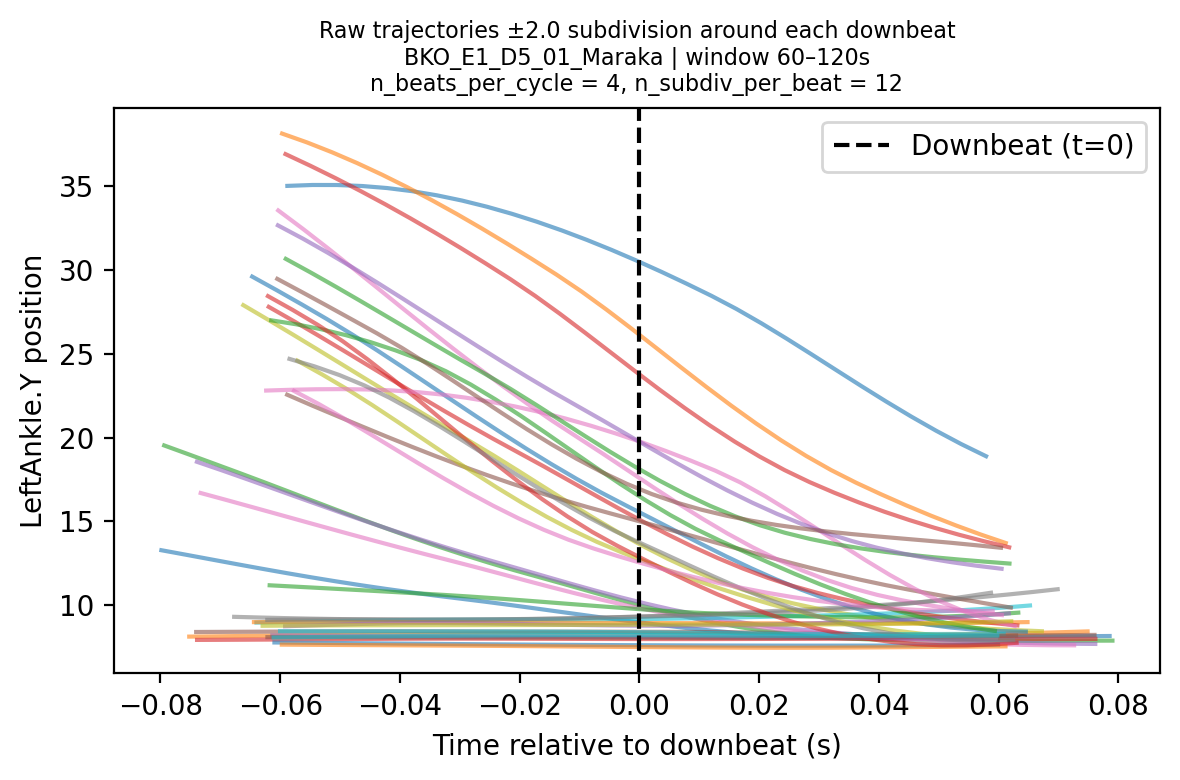

In [22]:

file_name       = "BKO_E1_D5_01_Maraka"
cycles_csv_path = f"data/virtual_cycles/{file_name}_C.csv"

joint_name      = "LeftAnkle"  
axis            = 'y'
worldpos_file   = os.path.join("extracted_mocap_csv", f"{file_name}_T_worldpos.csv")
W_start, W_end = 60, 120

n_beats_per_cycle = 4
n_subdiv_per_beat = 12

nn = 2
window_size_subdiv = 2.0 * nn   # e.g. 1.0 → ±½; 2.0 → ±1 subdivision; 0.5 → ±¼ subdivision

# 1) Load and filter world‐position data
world_positions = pd.read_csv(worldpos_file)
time_col        = world_positions.columns[0]            # e.g. "time"
pos_col         = f"{joint_name}.{axis.upper()}"        # e.g. "LeftAnkle.Y"

mask_wp = (world_positions[time_col] >= W_start) & \
          (world_positions[time_col] <= W_end)
world_positions = world_positions.loc[mask_wp].reset_index(drop=True)

# Load and filter cycle onsets
cycles_df = pd.read_csv(cycles_csv_path)
mask_cyc  = (cycles_df["Virtual Onset"] >= W_start) & \
            (cycles_df["Virtual Onset"] <= W_end)
cycles_df = cycles_df.loc[mask_cyc].reset_index(drop=True)

#  Prepare onsets & durations
onsets     = cycles_df["Virtual Onset"].values
# drop the last onset if it has no next onset to define a full cycle
onsets     = onsets[:-1]
durations  = np.diff(cycles_df["Virtual Onset"].values)

# Plot each ±1‐subdivision snippet
plt.figure(figsize=(6,4), dpi=200)
for onset, cycle_len in zip(onsets, durations):
    beat_len    = cycle_len / n_beats_per_cycle     # 4 beats per cycle
    subdiv_len = beat_len  / n_subdiv_per_beat       # 12 subdivisions per cycle
    
    half_win   = subdiv_len * (window_size_subdiv / 2.0)

    # select the small window around this downbeat
    m = ((world_positions[time_col] >= onset - half_win) &
         (world_positions[time_col] <= onset + half_win))

    t_rel = world_positions.loc[m, time_col] - onset
    v     = world_positions.loc[m, pos_col]

    plt.plot(t_rel, v, alpha=0.6)


plt.axvline(0, color='k', linestyle='--', label="Downbeat (t=0)")
plt.xlabel("Time relative to downbeat (s)")
plt.ylabel(f"{joint_name}.{axis.upper()} position")
plt.title(
    f"Raw trajectories ±{window_size_subdiv / 2.0} subdivision around each downbeat\n"
    f"{file_name} | window {W_start}–{W_end}s\n"
    f"n_beats_per_cycle = {n_beats_per_cycle}, n_subdiv_per_beat = {n_subdiv_per_beat}",
    fontsize=8
)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
